In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# **Breast Cancer Detection**

In [2]:
%config Completer.use_jedi = False
%load_ext watermark
%watermark

2021-01-25T22:41:36-05:00

CPython 3.7.3
IPython 7.19.0

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1127.19.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 16
interpreter: 64bit


In [3]:
'''
Data processing librarirs
'''
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

'''
Visualization libraries
'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook",font_scale=1)

'''
ML libraries
'''
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
'''
metrics libraries
'''
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

In [4]:
# load column names of the dataset
with open('data/field_names.txt',"r") as f:
    fields = [col.replace('\n','') for col in f.readlines()]

# load the 
data = pd.read_csv('data/breast-cancer.csv',header=None, names=fields)
data.set_index('ID',inplace=True)
data.head()

diagnosis  radius_mean  radius_sd_error  radius_worst  texture_mean  \
ID                                                                             
842302           M        17.99            10.38        122.80        1001.0   
842517           M        20.57            17.77        132.90        1326.0   
84300903         M        19.69            21.25        130.00        1203.0   
84348301         M        11.42            20.38         77.58         386.1   
84358402         M        20.29            14.34        135.10        1297.0   

          texture_sd_error  texture_worst  perimeter_mean  perimeter_sd_error  \
ID                                                                              
842302             0.11840        0.27760          0.3001             0.14710   
842517             0.08474        0.07864          0.0869             0.07017   
84300903           0.10960        0.15990          0.1974             0.12790   
84348301           0.14250        0.28390          0.2414             0.10520   
84358402           0.10030        0.13280          0.1980             0.10430   

          perimeter_worst  ...  concavity_worst  concave_points_mean  \
ID                         ...                                         
842302             0.2419  ...            25.38                17.33   
842517             0.1812  ...            24.99                23.41   
84300903           0.2069  ...            23.57                25.53   
84348301           0.2597  ...            14.91                26.50   
84358402           0.1809  ...            22.54                16.67   

          concave_points_sd_error  concave_points_worst  symmetry_mean  \
ID                                                                       
842302                     184.60                2019.0         0.1622   
842517                     158.80                1956.0         0.1238   
84300903                   152.50                1709.0         0.1444   
84348301                    98.87                 567.7         0.2098   
84358402                   152.20                1575.0         0.1374   

          symmetry_sd_error  symmetry_worst  fractal_dimension_mean  \
ID                                                                    
842302               0.6656          0.7119                  0.2654   
842517               0.1866          0.2416                  0.1860   
84300903             0.4245          0.4504                  0.2430   
84348301             0.8663          0.6869                  0.2575   
84358402             0.2050          0.4000                  0.1625   

          fractal_dimension_sd_error  fractal_dimension_worst  
ID                                                             
842302                        0.4601                  0.11890  
842517                        0.2750                  0.08902  
84300903                      0.3613                  0.08758  
84348301                      0.6638                  0.17300  
84358402                      0.2364                  0.07678  

[5 rows x 31 columns]

Before setting aside test and validation datasets, check for any class imbalance.

In [5]:
data.diagnosis.value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

The benign (B) class is in higher proportion then the  malignant (M) class. 

Set aside validation and test sets maintaining the class proportionality.

In [6]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_idx, test_idx in split.split(data, data['diagnosis']):
    train  = data.iloc[train_idx]
    test = data.iloc[test_idx]
    
split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_idx, test_idx in split.split(test, test['diagnosis']):
    val  = data.iloc[val_idx]
    test = data.iloc[test_idx]

print('TRAIN: %.0f%%' %(len(train)/len(data)*100))
print('VAL: %.0f%%' %(len(val)/len(data)*100))
print('TEST: %.0f%%' %(len(test)/len(data)*100))

TRAIN: 70%
VAL: 15%
TEST: 15%


In [7]:
# Check target proportions in three sets are similar
print('TRAIN')
print(train.diagnosis.value_counts(normalize=True))
print("VAL")
print(val.diagnosis.value_counts(normalize=True))
print("TEST")
print(test.diagnosis.value_counts(normalize=True))

TRAIN
B    0.628141
M    0.371859
Name: diagnosis, dtype: float64
VAL
M    0.552941
B    0.447059
Name: diagnosis, dtype: float64
TEST
B    0.511628
M    0.488372
Name: diagnosis, dtype: float64


Their proportions are similar across both sets. 

Moving forward, only train sets will be used for exploration, processing, feature engineering and modeling.


In [8]:
## Check data type for all variables
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 8610862 to 866674
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   diagnosis                   398 non-null    object 
 1   radius_mean                 398 non-null    float64
 2   radius_sd_error             398 non-null    float64
 3   radius_worst                398 non-null    float64
 4   texture_mean                398 non-null    float64
 5   texture_sd_error            398 non-null    float64
 6   texture_worst               398 non-null    float64
 7   perimeter_mean              398 non-null    float64
 8   perimeter_sd_error          398 non-null    float64
 9   perimeter_worst             398 non-null    float64
 10  area_mean                   398 non-null    float64
 11  area_sd_error               398 non-null    float64
 12  area_worst                  398 non-null    float64
 13  smoothness_mean           

All variables are numerical except the target (``diagnosis``) which is categorical. 
There also does not seem to be any missing values, but let's double check.


In [9]:
## Check for missing values
train.isnull().sum()

diagnosis                     0
radius_mean                   0
radius_sd_error               0
radius_worst                  0
texture_mean                  0
texture_sd_error              0
texture_worst                 0
perimeter_mean                0
perimeter_sd_error            0
perimeter_worst               0
area_mean                     0
area_sd_error                 0
area_worst                    0
smoothness_mean               0
smoothness_sd_error           0
smoothness_worst              0
compactness_mean              0
compactness_sd_error          0
compactness_worst             0
concavity_mean                0
concavity_sd_error            0
concavity_worst               0
concave_points_mean           0
concave_points_sd_error       0
concave_points_worst          0
symmetry_mean                 0
symmetry_sd_error             0
symmetry_worst                0
fractal_dimension_mean        0
fractal_dimension_sd_error    0
fractal_dimension_worst       0
dtype: i

No missing values, good!

Check distributions of all numerical variables.

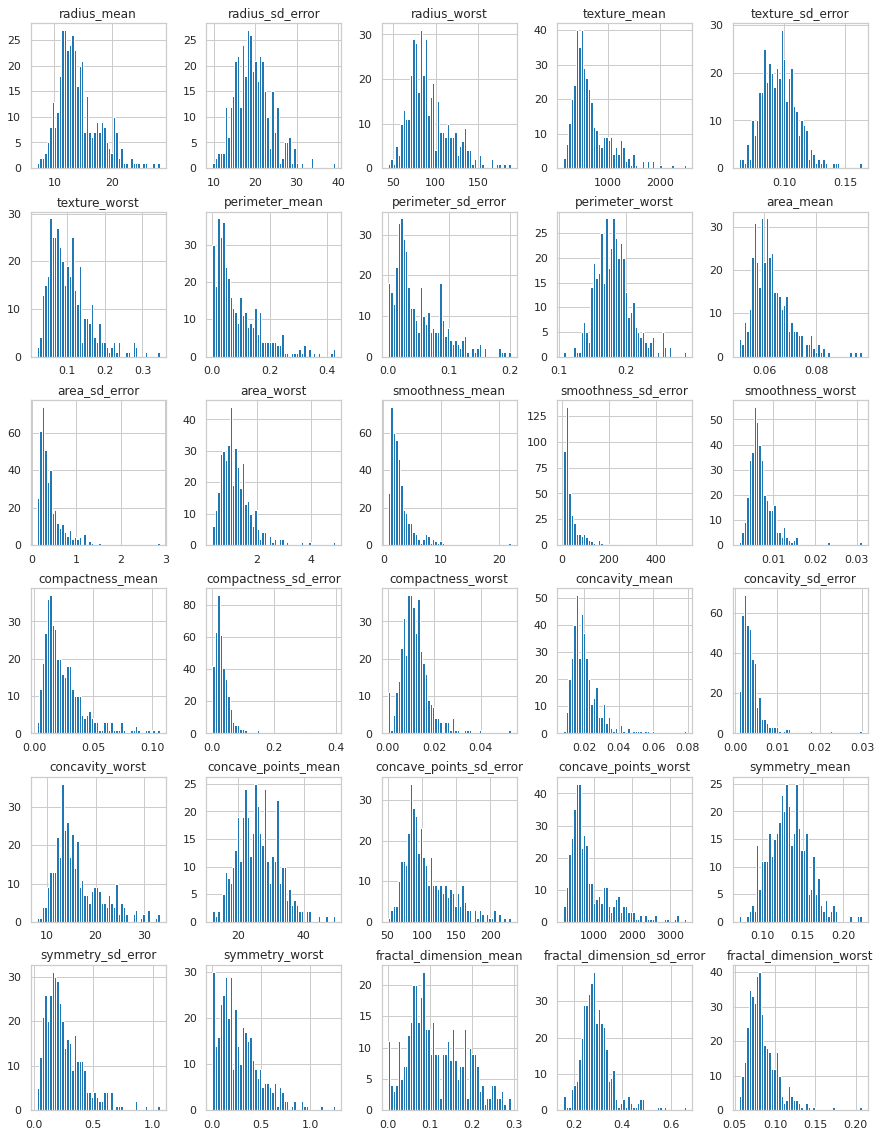

In [10]:
_=train.hist(bins=50, figsize=(15,20))

All numerical variables are continuous. 
All variables are non-normally distributed and have varying degrees of positive skewness.


It can be argued that following variables are normally distributed:
   - `radius_sd_error`
   - `texture_sd_error`
   - `perimeter_worst`
   - `concave_points_mean`
   - `symmetry_mean`
   - `fractal_dimension_sd_error`
   
However, lets apply log transform to all continuous variables and see if their distributions become more normal.


In [11]:
cont_vars = train.drop('diagnosis',axis=1).columns

In [12]:
# Logarithm transform
class LogTransform(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None):
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # This step is not needed, but to accomodate the pipeline
        return self
    
    def transform(self, X):
        X = X.copy()
        
        for feature in self.variables:
            X[feature] = np.log1p(X[feature])
            
        return X
    
def transform(df,var_list):
    ''' Applies log transformation to df'''
    df = df.copy()
    logTransformer = LogTransform(variables=var_list)
    df = logTransformer.transform(df)
    return df

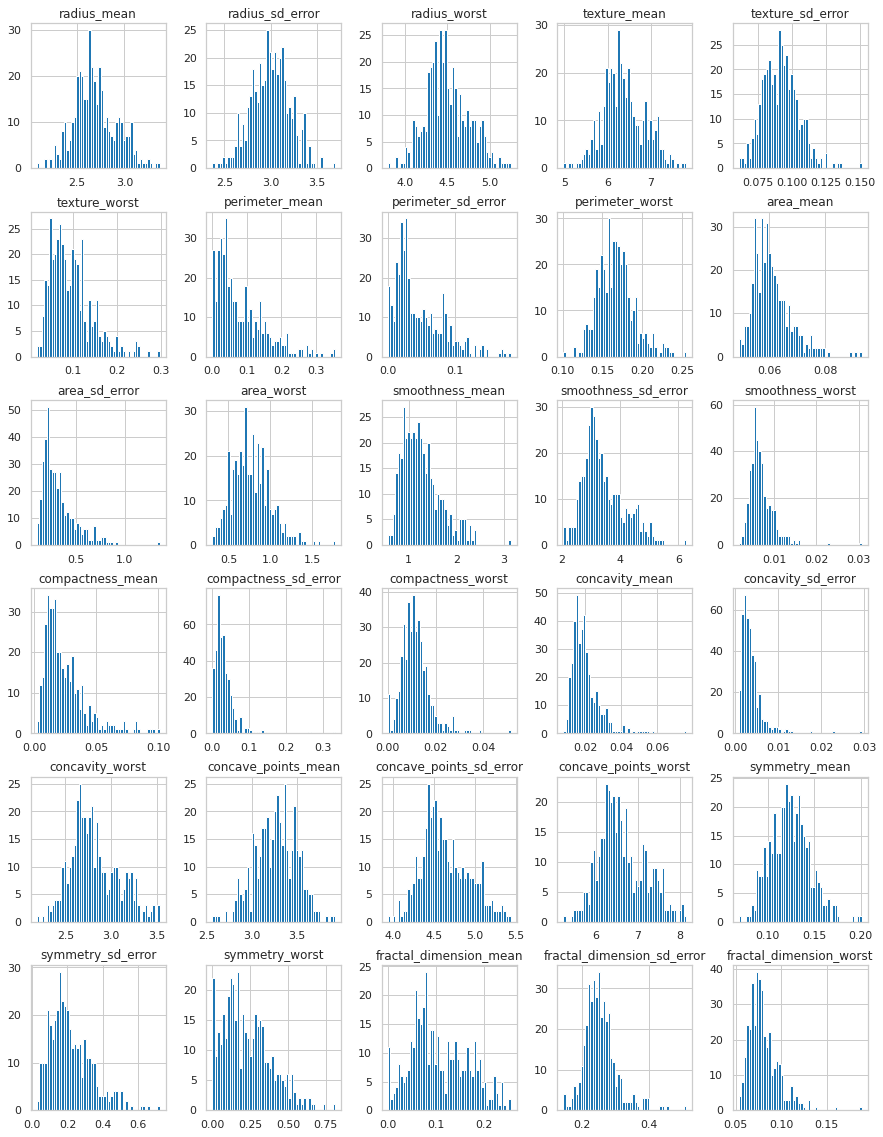

In [13]:
def analyze_transformed_distribution(df,var_list):
    df = transform(df,var_list)
    _=df.hist(bins=50, figsize=(15,20))
    
analyze_transformed_distribution(train,cont_vars)

Transforming the variables has helped in making distributions of most variables look like a normal distribution. 

### Bivariate analysis 

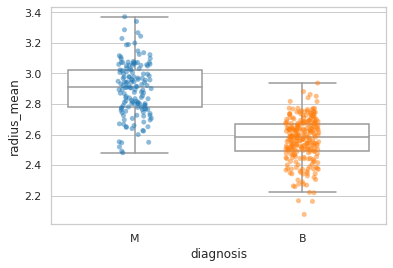

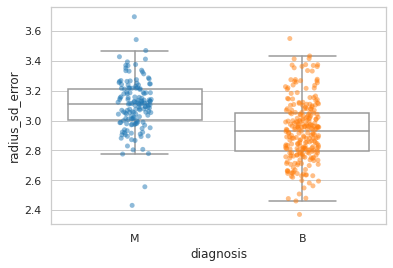

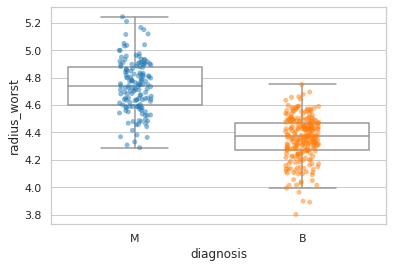

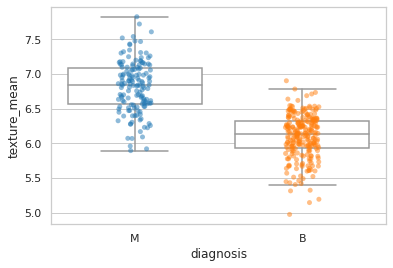

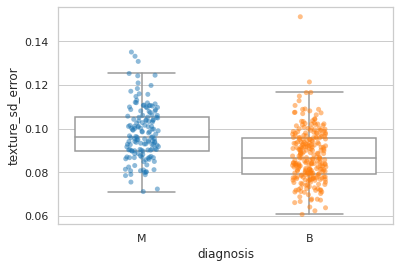

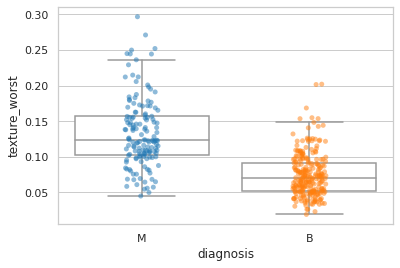

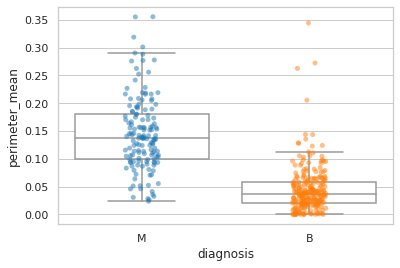

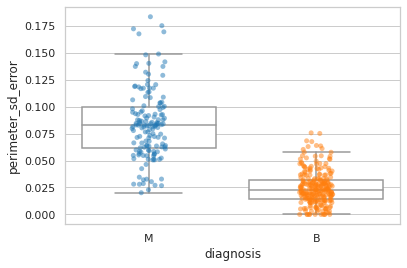

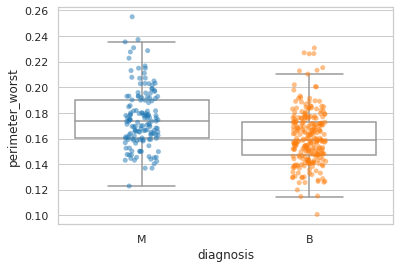

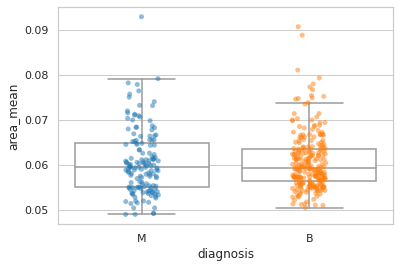

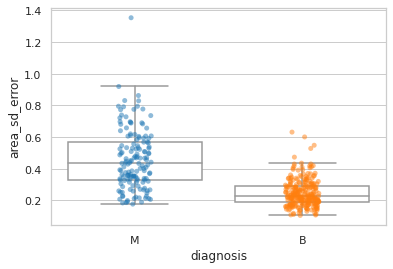

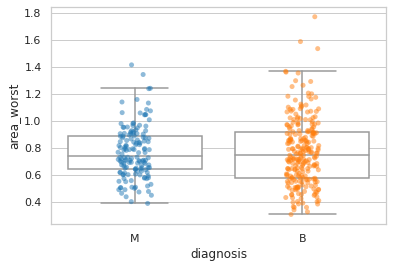

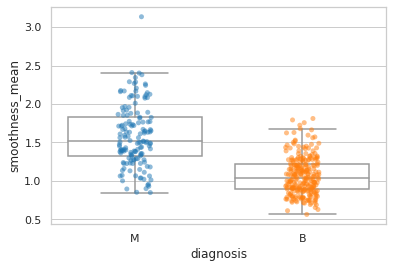

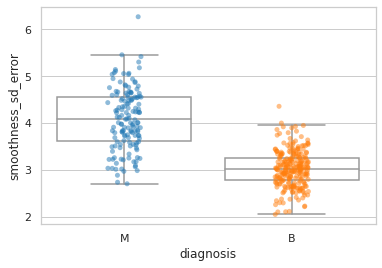

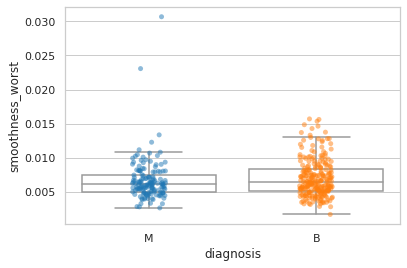

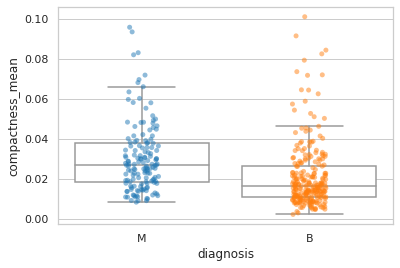

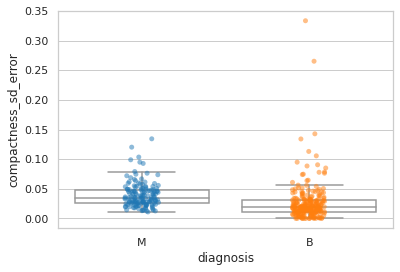

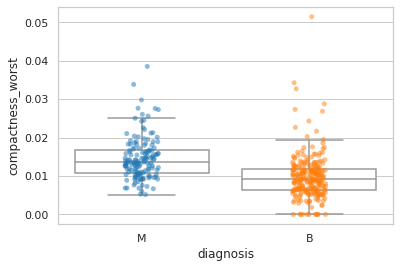

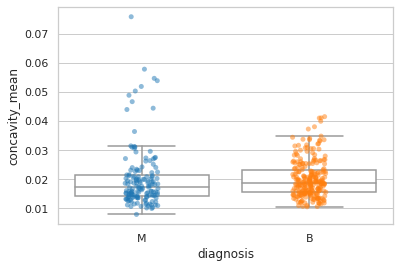

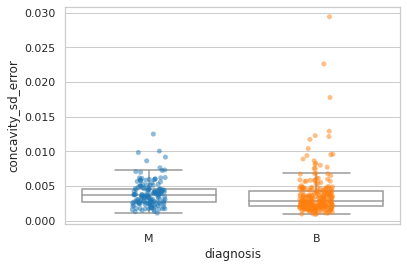

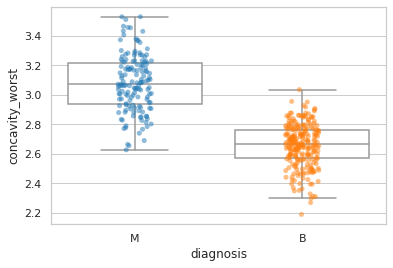

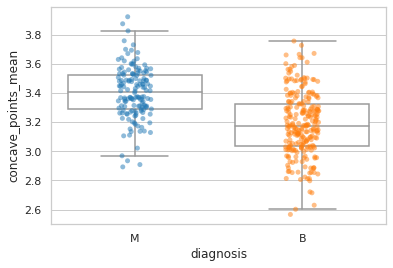

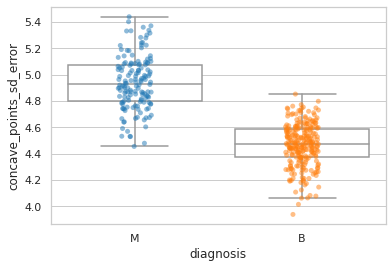

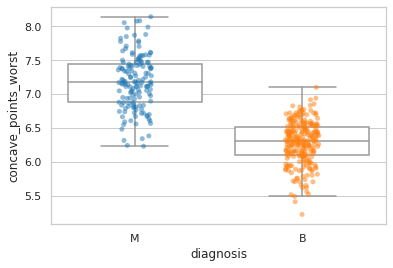

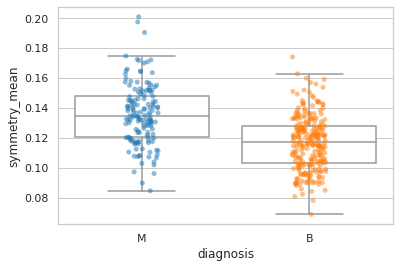

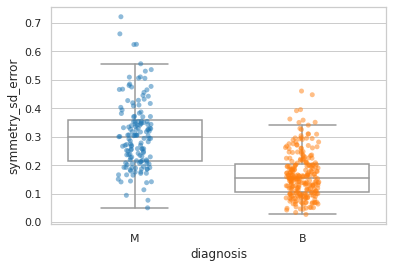

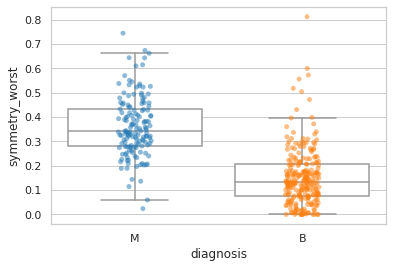

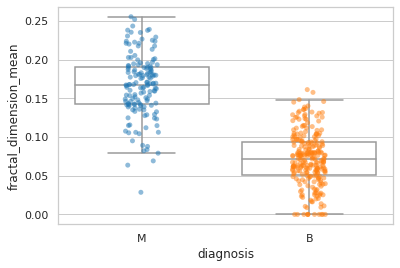

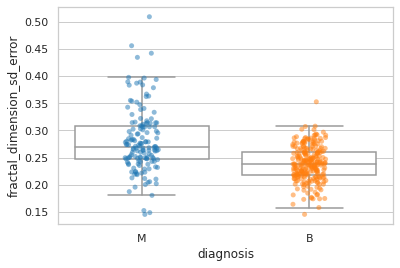

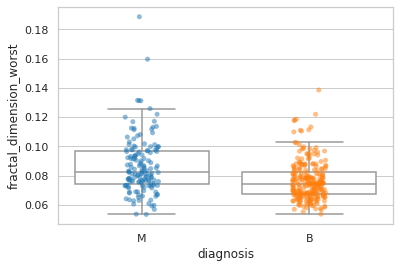

In [14]:
def analyse_transformed_continuous(df, var):
    df = transform(df,var)
    plt.figure()
    sns.boxplot(x='diagnosis',y=var, data=df,
                color='white',order=['M','B'],
                showfliers = False)
    
    sns.stripplot(x='diagnosis',y=var, data=df,
                  palette=['C0','C1'],
                  order=['M','B'],alpha=0.5)
    
for var in cont_vars:
    analyse_transformed_continuous(train,var)

Following features are potentially predictive of a malignant tumor: their values vary across the two tumor classes considerably.
   - radius_mean
   - radius_worst
   - perimeter_mean
   - perimeter_sd_error
   - area_sd_error
   - smoothness_mean
   - smoothness_sd_error
   - concavity_worst
   - concave_points_sd_error
   - concave_points_worst
   - symmetry_sd_error
   - symmetry_worst
   - fractal_dimension_mean 
   
There are also several outliers, but we will explore those further with multivariate analysis.
   
Let's check correlations between them.


In [15]:
imp_feat = ['radius_mean', 'radius_worst', 
            'texture_mean', 'texture_worst', 
            'perimeter_mean', 'perimeter_sd_error',
            'area_sd_error', 'smoothness_mean', 
            'smoothness_sd_error', 'concavity_worst', 
            'concave_points_sd_error', 'concave_points_worst', 
            'symmetry_sd_error', 'symmetry_worst', 
            'fractal_dimension_mean']

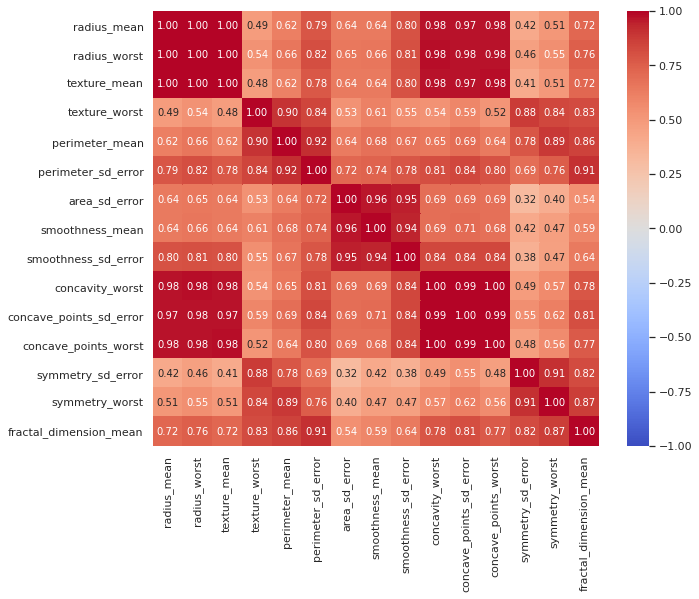

In [16]:
# Check correlation between features
def plot_corr(df,var_list):
    df = transform(df,var_list)
    plt.figure(figsize=(10,8))
    _=sns.heatmap(df[var_list].corr(),vmin=-1,vmax=1,cmap='coolwarm',fmt='.2f',annot=True,annot_kws=dict(size=10))
    
plot_corr(train,imp_feat)

Several features are highly correlated. Having correlated features in the model can lead to highly unstable estimates and therefore unreliable feature importance weights.

We will remove features that have a correlation equal to or greater than .99:
   - radius_worst
   - texture_mean
   - concavity_worst
   - concave_points_sd_error

### Multivariate Analysis

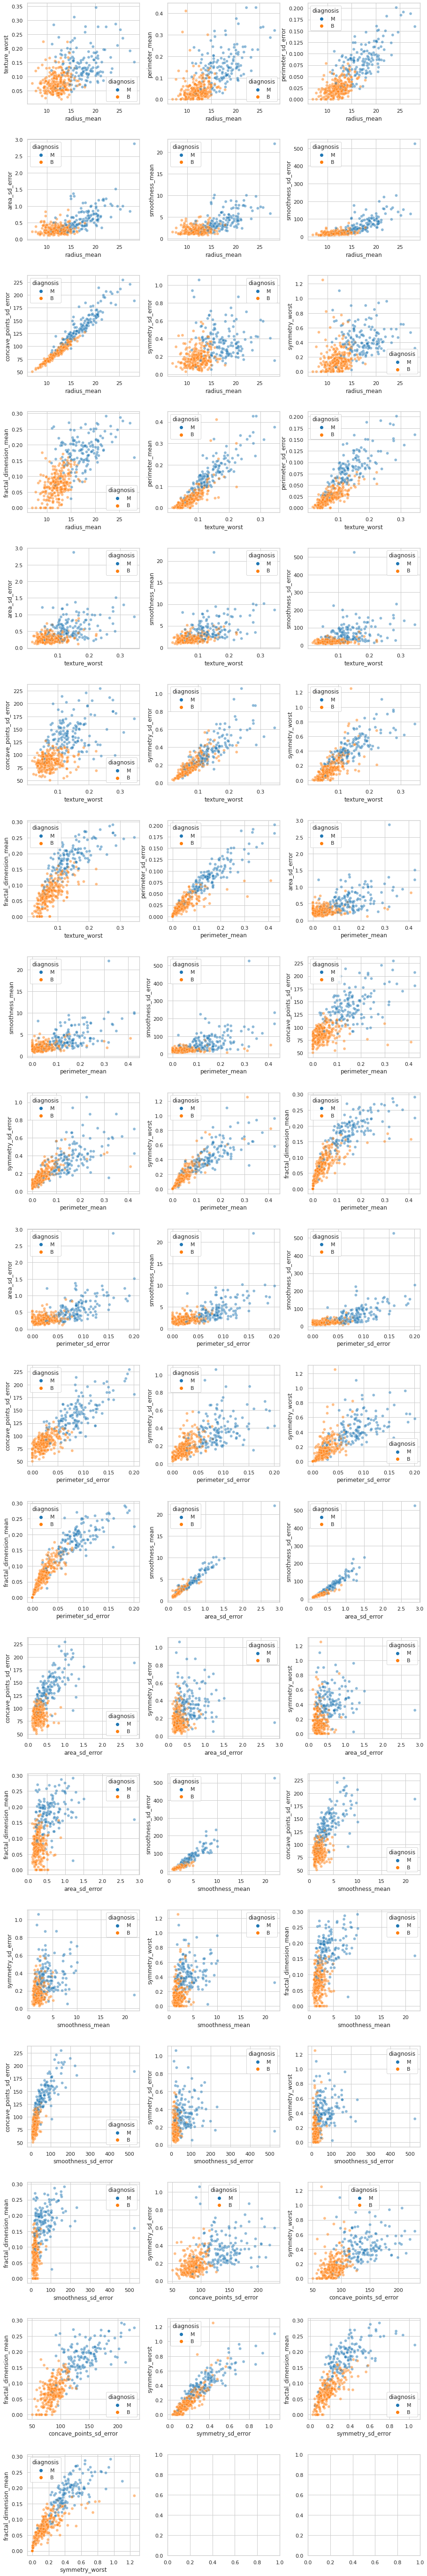

In [17]:
exclude_feat = ['radius_worst','texture_mean',
                'concavity_worst','concave_points_worst']

imp_feat = [feat for feat in imp_feat if feat not in exclude_feat]

var_pairs = []
counter = 1
for var1 in imp_feat:
    for var2 in imp_feat[counter:]:
        var_pairs.append((var1,var2))
    counter += 1
    
def analyze_multivariate_scatter(df,var_pairs):
    df = transform(df,cont_vars)
    
    fig, axes = plt.subplots(nrows=19,ncols=3,figsize=(15,100))
    axes=axes.flatten()
    fig.subplots_adjust(hspace=0.35,wspace=0.25)
    
    for ii, var_pair in enumerate(var_pairs):
        var1, var2 = var_pair
        sns.scatterplot(x=var1,y=var2,data=train,ax=axes[ii],hue='diagnosis',alpha=0.5)
        
analyze_multivariate_scatter(train,var_pairs)

One data point is highly spurious in the `smoothness_mean` vs. `area_sd_mean` plot. It is likely an outlier.  
Let's remove the row with the highest value for `area_sd_mean`.

In [18]:
area_sd_error = train['area_sd_error'].sort_values(ascending = False).iloc[1]
print(area_sd_error)

1.509


In [19]:
class RemoveOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, dictionary):
        self.dictionary = dictionary
        
    def fit(self,X, y = None):
        # only to accomodate the sklearn pipeline
        return self
    def transform(self,X):
        X = X.copy()
        for var, val in self.dictionary.items():
            X = X[X[var]<=val]
        return X

In [20]:
removeOutliers = RemoveOutliers({'area_sd_error':area_sd_error})
print(train.shape)
train = removeOutliers.transform(train)
print(train.shape)

(398, 31)
(397, 31)


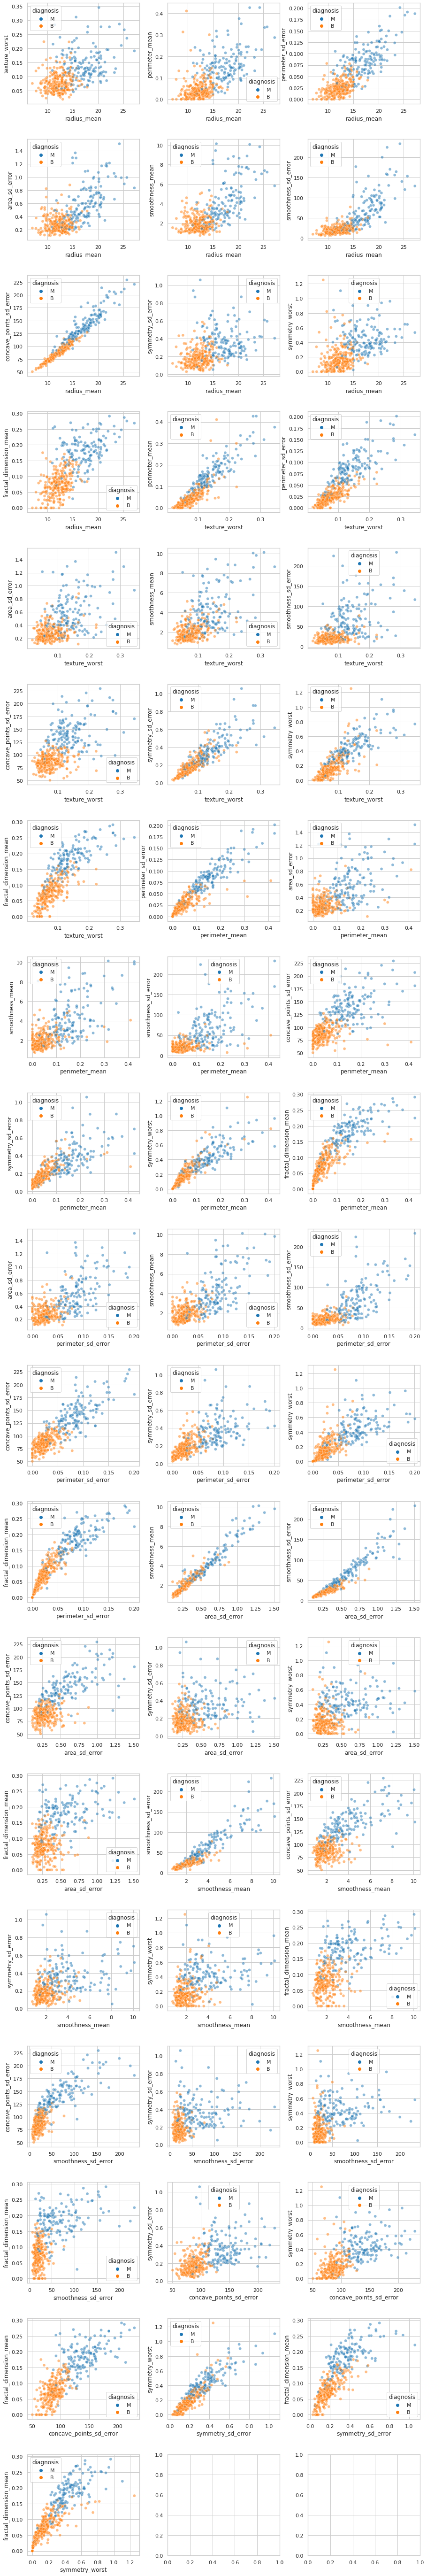

In [21]:
analyze_multivariate_scatter(train,var_pairs)

After removing the outlier (rows with `area_sd_error` > 1.509), the data points look reasonably within the range.

Earlier, through visualization we identified following variables as highly predictive of a malignant tumor.

In [30]:
for var in enumerate(imp_feat):
    print(var)

(0, 'radius_mean')
(1, 'texture_worst')
(2, 'perimeter_mean')
(3, 'perimeter_sd_error')
(4, 'area_sd_error')
(5, 'smoothness_mean')
(6, 'smoothness_sd_error')
(7, 'concave_points_sd_error')
(8, 'symmetry_sd_error')
(9, 'symmetry_worst')
(10, 'fractal_dimension_mean')


We will use a more principled approach of identify important variables using PCA.

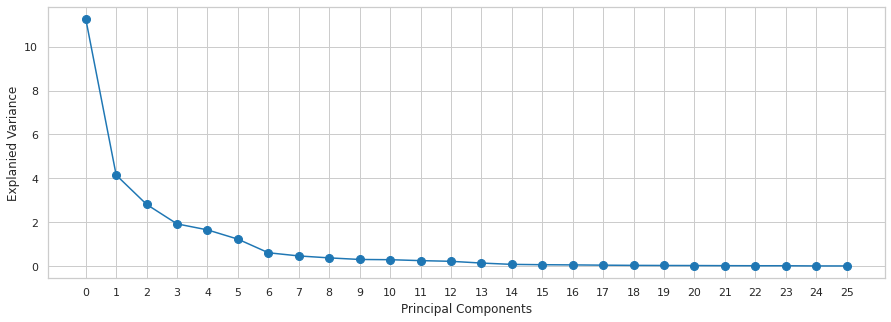

In [31]:
# Initialize a new PCA model with a default number of components.

def plot_pca(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X_std = scaler.transform(X)
    
    pca = PCA()
    pca.fit(X_std)

    # Do the rest on your own :)
    plt.figure(figsize=(15,5))
    plt.plot(list(range(X_std.shape[1])),pca.explained_variance_,marker='o',markersize=8)
    _=plt.xticks(list(range(X_std.shape[1])))
    _=plt.xlabel('Principal Components')
    _=plt.ylabel('Explanied Variance')
    
plot_pca(train[[var for var in cont_vars if var not in exclude_feat]])

First two components account for most variance in the data. This variance can potentially be contributing to class separability. Lets analyze this further by plotting the first two components. 

<AxesSubplot:xlabel='diagnosis', ylabel='PC2'>

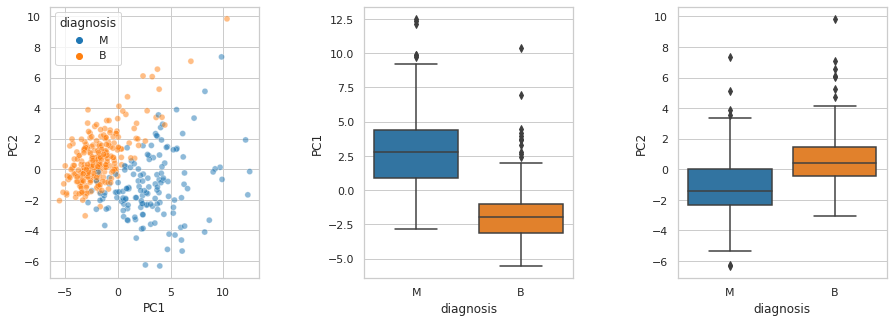

In [32]:
# PCA to reduce dimensions to 2, so the clusters can be visualized
pca = PCA(n_components=2)
scaler = StandardScaler()
X_std = scaler.fit_transform(train[[var for var in cont_vars if var not in exclude_feat]])
pca_features = pca.fit_transform(X_std)

pca_table = pd.DataFrame(dict(PC1=pca_features[:,0],PC2=pca_features[:,1], 
                              diagnosis=train['diagnosis']),
                         index=train.index)

plt.figure(figsize=(15,5))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,3,1)
sns.scatterplot(x='PC1',
                y='PC2',
                hue='diagnosis',
                data=pca_table,
                palette=sns.color_palette(n_colors=2),
                alpha=0.5)

#plt.legend(loc='center right',bbox_to_anchor=[1.2,0.5])

plt.subplot(1,3,2)
sns.boxplot(x='diagnosis',y='PC1',data=pca_table)

plt.subplot(1,3,3)
sns.boxplot(x='diagnosis',y='PC2',data=pca_table)

First component (PC1) is highly predictive of a malignant tumor. The interquartile ranges of the two classes overlap for the second component (PC2), hence PC2 does not have as much predictive power. 

Let's check the loading of the first component on the features.

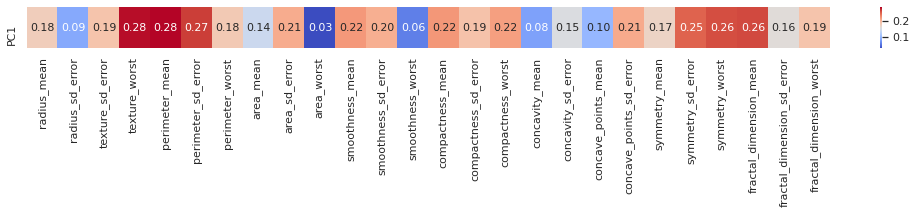

In [33]:
pca_df = pd.DataFrame(pca.components_[0,:], index=[var for var in cont_vars if var not in exclude_feat],
                      columns=['PC1']).T

plt.figure(figsize=(18,0.75))
_=sns.heatmap(pca_df,vmin=np.min(pca.components_[0,:]),
              vmax=np.max(pca.components_[0,:]),cmap='coolwarm',
              annot_kws={'size':11},annot=True,fmt='.2f')

`texture_worst`, `perimeter_mean`, `perimeter_sd_error` have the highest loading. These three variables were also identified as important features during visualizations in the early part of this notebook.

For the benefit of the readers, we have re-plotted them below. Notice the interquartile ranges of the two classes do not overlap for any of the three features mentioned below. This indicates that the variance in these features are predictive of the tumor class.

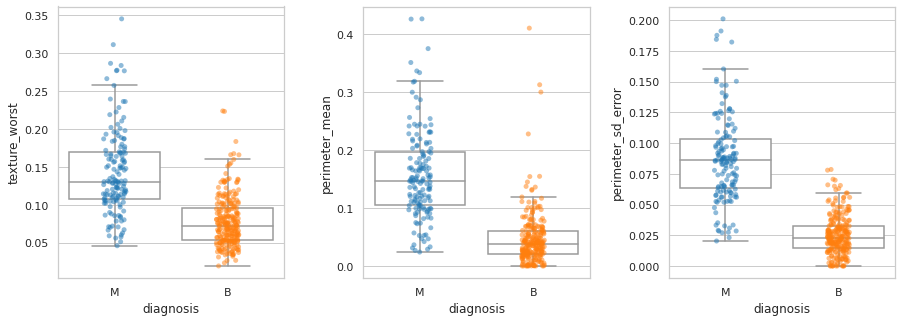

In [34]:
fig, axes = plt.subplots(ncols=3,figsize=(15,5))
fig.subplots_adjust(wspace=0.35)
for ii,var in enumerate(['texture_worst', 'perimeter_mean', 'perimeter_sd_error']):
    sns.boxplot(x='diagnosis',y=var, data=train,
                color='white',order=['M','B'],
                showfliers = False,ax=axes[ii])
    
    sns.stripplot(x='diagnosis',y=var, data=train,
                  palette=['C0','C1'],
                  order=['M','B'],alpha=0.5,ax=axes[ii])

# Modeling

In [35]:
k_seed = 42

features = [var for var in cont_vars if var not in exclude_feat]

preproc_pipeline = Pipeline(
    [('removeOutliers',RemoveOutliers({'area_sd_error':area_sd_error})),
     ('logTransform',LogTransform(features)),
     ('scale',StandardScaler())]
)

preproc_pipeline.fit(train[features])
X_train = pd.DataFrame(preproc_pipeline.transform(train[features]),columns=features)
y_train = train['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)

X_val = pd.DataFrame(preproc_pipeline.transform(val[features]),columns=features)
y_val = val['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)

In [36]:
def mean_cv_score(estimator, X, y, dset='Train'):
    #score = cross_val_score(estimator, X, y , cv=cv, scoring=scoring)
    y_pred = estimator.predict(X)
    print('{} mean accuray: {:.2f}'.format(dset,metrics.accuracy_score(y,y_pred)))
    print('{} recall accuray: {:.2f}'.format(dset,metrics.recall_score(y,y_pred)))
    #print('{} {}: {:.2f}'.format(dset,scoring,np.mean(score)))
    return np.mean(y_pred)

def _report(estimator,X,y,dset='Train'):
    """
    Reports multiple classification metrics
    
    Inputs
    ------
    estimator: ML model
    X: feature dataframe
    y: traget feature
    
    Return
    ------
    prints classification metrics
    """
    y_pred =  estimator.predict(X)
    print('\n'+dset+':')
    print('Confusion matrix:')
    print(metrics.confusion_matrix(y,y_pred))
    #print('\nClassification report:')
    #print(classification_report(y,y_pred))

### Baseline classifier: Majority Class Classifier


Classifier that always predicts the frequent class.

In [37]:
dc = DummyClassifier(strategy="most_frequent", random_state=k_seed)
dc.fit(X_train,y_train)
_=mean_cv_score(dc, X_train, y_train,dset='Train')
print('\n')
_=mean_cv_score(dc, X_val, y_val,dset='Val')

Train mean accuray: 0.63
Train recall accuray: 0.00


Val mean accuray: 0.45
Val recall accuray: 0.00


Baseline accuracy is 63%. We have to develop a model that gives an accuray that is considerably greater than 63%.

For disease diagnosis, a model that has 100% recall, i.e., a model that predicts all malignant tumors as malignant, is desirable. 
It is tolerable to trade a slightly lower precision for a higher recall. However at the same time, we don't 
want a model that predicts all tumors as malignant. Hence, we need a model that has maximum recall, but at the same time has an accuracy that is significantly greater than the baseline accuracy of 63%.

Three models namely, Logistic regression (LR), SVM, and Random Forest (RF) will be trained and evaluated using a nested cross validation. Model that has the highest recall and an accuracy significantly greater than 63% will be our final model choice.

In order to avoid overfitting, the original data has been divided into three sets: train (70%), validation (15%), and test (%15). The model will be trained using the training set, and evaluated on the validation set. The idea behind this to assess how well the model performs on new data. If the model makes accurate predictions on the training set but not on the validation set, then it means the model is suffering from overfitting. Model hyperparameters can be optimized to reduce overfitting. Splitting the data into three sets (as we have done here) is particularly useful as it allows us to try and test several combinations of model hyperparameters using just the training and validation set. Once we have hyperparameters that yield accurate predictions on both training and validation sets, we can retrain the final model on the combined training and validation datasets and test it on the test set.  

### Logistic Regression Classifier

In [38]:
#metric = 'recall'
param_grid = {'penalty':['elasticnet'],
              'C':[1,0.6,0.3,0.1],
              'l1_ratio':[0,0.25,0.5,0.75,1]}

lr = LogisticRegression(solver='saga',class_weight='balanced',random_state=k_seed)
lr_cv = GridSearchCV(lr,param_grid=param_grid,cv=5,n_jobs=-1,scoring='recall')
_=lr_cv.fit(X_train,y_train)
print('Best parameters:',lr_cv.best_params_)
print('\n')
mean_cv_score(lr_cv.best_estimator_,X_train,y_train)
print('\n')
mean_cv_score(lr_cv.best_estimator_,X_val,y_val,dset='Val')
_report(lr_cv.best_estimator_,X_train,y_train)
_report(lr_cv.best_estimator_,X_val,y_val,dset='Val')

Best parameters: {'C': 1, 'l1_ratio': 0, 'penalty': 'elasticnet'}


Train mean accuray: 0.98
Train recall accuray: 0.97


Val mean accuray: 0.96
Val recall accuray: 0.94

Train:
Confusion matrix:
[[247   3]
 [  4 143]]

Val:
Confusion matrix:
[[38  0]
 [ 3 44]]


### SVM Classifier

In [39]:
param_grid = {'C':[1,0.3,0.1,0.03,0.01],
              'kernel':['linear','poly','rbf']}

svc = SVC(class_weight="balanced",random_state=k_seed)
svc_cv = GridSearchCV(svc,param_grid=param_grid,cv=5,n_jobs=-1,scoring='recall')
_=svc_cv.fit(X_train,y_train)
print('Best parameters:',svc_cv.best_params_)
print('\n')
_=mean_cv_score(svc_cv.best_estimator_,X_train,y_train)
print('\n')
_=mean_cv_score(svc_cv.best_estimator_,X_val,y_val,dset='Val')
_report(svc_cv.best_estimator_,X_train,y_train)
_report(svc_cv.best_estimator_,X_val,y_val,dset='Val')

Best parameters: {'C': 0.3, 'kernel': 'rbf'}


Train mean accuray: 0.98
Train recall accuray: 0.97


Val mean accuray: 0.96
Val recall accuray: 0.94

Train:
Confusion matrix:
[[246   4]
 [  5 142]]

Val:
Confusion matrix:
[[38  0]
 [ 3 44]]


### Random Forest

In [40]:
param_grid = {"n_estimators":[100,250,500,750,1000],
              "max_features":["auto","sqrt","log2"]}
rf = RandomForestClassifier(class_weight="balanced")
rf_cv = GridSearchCV(rf,param_grid=param_grid,cv=5,n_jobs=-1,scoring='recall')
_=rf_cv.fit(X_train,y_train)
print('Best parameters:',rf_cv.best_params_)
print('\n')
_=mean_cv_score(rf_cv.best_estimator_,X_train,y_train)
print('\n')
_=mean_cv_score(rf_cv.best_estimator_,X_val,y_val,dset='Val')
_report(rf_cv.best_estimator_,X_train,y_train)
_report(rf_cv.best_estimator_,X_val,y_val,dset='Val')

Best parameters: {'max_features': 'log2', 'n_estimators': 100}


Train mean accuray: 1.00
Train recall accuray: 1.00


Val mean accuray: 0.99
Val recall accuray: 0.98

Train:
Confusion matrix:
[[250   0]
 [  0 147]]

Val:
Confusion matrix:
[[38  0]
 [ 1 46]]


In [52]:
val_summary = pd.DataFrame([['Mojority','Train',.63, 0],
                            ['Mojority','Val',0.45, 0],
                            ['Linear Regression','Train',.98,.97],
                            ['Linear Regression','Val',.96,.94],
                            ['SVC','Train',.98,.97],
                            ['SVC','Val',.96,.94],
                            ['Random Forest','Train',1,1],
                            ['Random Forest','Val',.99,.98]],
                           columns=['Classifier','dset','Accuracy','Recall'])

print('Performance summary on the validation set:\n')
print(val_summary[val_summary['dset']=='Val'].drop(columns='dset'))

Performance summary on the validation set:

          Classifier  Accuracy  Recall
1           Mojority      0.45    0.00
3  Linear Regression      0.96    0.94
5                SVC      0.96    0.94
7      Random Forest      0.99    0.98


RF classifier has the highest recall compared to LR and SVM classifiers and a significantly greater accuracy than the baseline (45%) model. Lets plot the precision vs. recall curve for all the three models. Note: Mojority classifier 

In [42]:
def analyze_precision_vs_recall(estimator, X, y):
    if estimator.__class__.__name__ == "RandomForestClassifier":
        y_scores = rf_cv.best_estimator_.predict_proba(X_val)[:,1]
    else:
        y_scores = estimator.decision_function(X_val)
    precision, recalls, thresholds = metrics.precision_recall_curve(y,y_scores)
    plt.plot(recalls, precision, linewidth=3, label=estimator.__class__.__name__)
    plt.xlabel('Recall')
    plt.ylabel("Precision")

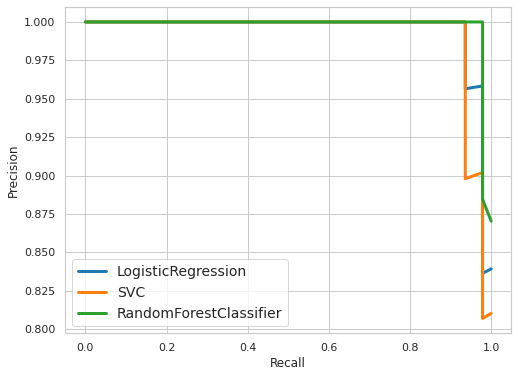

In [43]:
plt.figure(figsize=(8,6))
analyze_precision_vs_recall(lr_cv.best_estimator_,X_val,y_val)
analyze_precision_vs_recall(svc_cv.best_estimator_,X_val,y_val)
analyze_precision_vs_recall(rf_cv.best_estimator_,X_val,y_val)
_=plt.legend(fontsize=14)

As you can see, RF gives highest recall and precision compared to LR and SMV classifiers. 
Let's also analyze the ROC curve.


In [44]:
classifiers = [lr_cv.best_estimator_,
               svc_cv.best_estimator_,
               rf_cv.best_estimator_]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 
                                     'fpr1','tpr1',
                                     'fpr','tpr',
                                     'train_accuracy',
                                     'val_accuracy', 
                                     'train_auc', 
                                     'val_auc', 
                                     'f1_score', 
                                     'precision',
                                     'recall',
                                     'confusion matrix',
                                     'Report'])

# Train the models and record the results
for clf in classifiers:
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)
    
    train_accuracy= metrics.accuracy_score(y_train, y_train_pred)
    val_accuracy= metrics.accuracy_score(y_val, y_val_pred)
     
    fpr, tpr, _ = metrics.roc_curve(y_val,  y_val_pred)
    fpr1, tpr1, _ = metrics.roc_curve(y_train,  y_train_pred)
    
    train_auc = metrics.roc_auc_score(y_train, y_train_pred)
    val_auc = metrics.roc_auc_score(y_val, y_val_pred)
    
    f1_score_ = metrics.f1_score(y_val, y_val_pred)
    precision = metrics.precision_score(y_val, y_val_pred)
    recall = metrics.recall_score(y_val, y_val_pred)
    
    conf_mat= metrics.confusion_matrix(y_val,y_val_pred)
    report = metrics.classification_report(y_val,y_val_pred, digits=3, output_dict=True)
    
    result_table = result_table.append({'classifiers':clf.__class__.__name__,
                                        'fpr1':fpr1,
                                        'tpr1':tpr1,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'train_accuracy': train_accuracy,
                                        'val_accuracy': val_accuracy,
                                        'train_auc':train_auc,
                                        'val_auc':val_auc,
                                        'f1_score': f1_score_,
                                        'precision': precision,
                                        'recall': recall,
                                        'confusion matrix':conf_mat,
                                        'Report':report}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

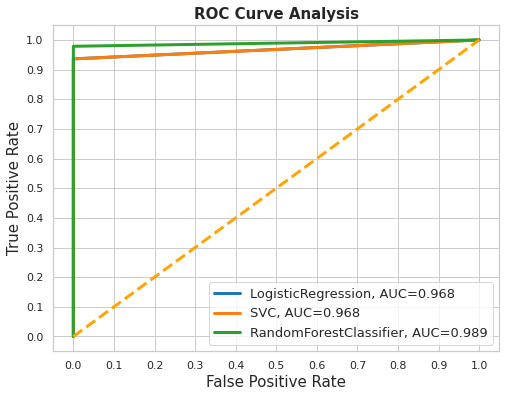

In [45]:
fig = plt.figure(figsize=(8,6))

for i in range(result_table.shape[0]):
    plt.plot(result_table.iloc[i,]['fpr'], 
             result_table.iloc[i,]['tpr'], 
             linewidth=3,
             label="{}, AUC={:.3f}".format(result_table.index[i], result_table.iloc[i,]['val_auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--', linewidth=3)
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

The ROC curve also indicates that the RF classifier gives the maximum True Positive Rate (TPR) as compared to the other two classifiers. The False Positive Rate (FPR) of RF is also close to 0.

### Feature Importance

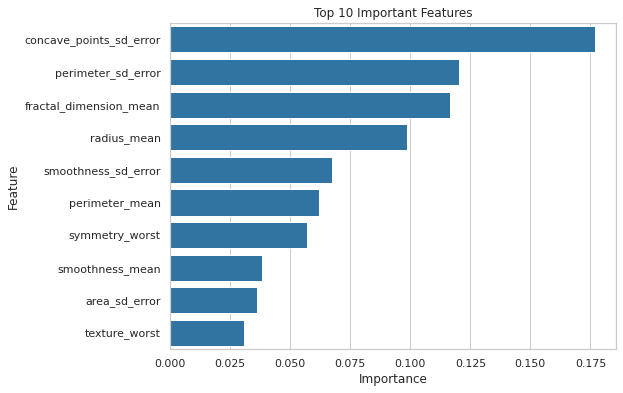

In [46]:
# Plot feature importance
feature_importance = pd.DataFrame(np.round(rf_cv.best_estimator_.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['Importance']).sort_values(by='Importance',
                                                                                            ascending=False)
feature_importance.index.name = 'Feature'
feature_importance.reset_index(inplace =True)

plt.figure(figsize=(8,6))
sns.barplot(y='Feature',x='Importance',data=feature_importance.sort_values('Importance',ascending=False)[:10],orient='h',color='C0')
_=plt.title('Top 10 Important Features')

Important features are those features that are highly predictive of the tumor class. The above plot shows top 10 features that are highly predictive of the tumor class.

Notice that two out of three features (`perimeter_sd_error`, `perimeter_mean`, and `texture_worst`) we had identified as being predictive of the tumor class are included in the top 10 features.

Lets visualize the top 10 important features.

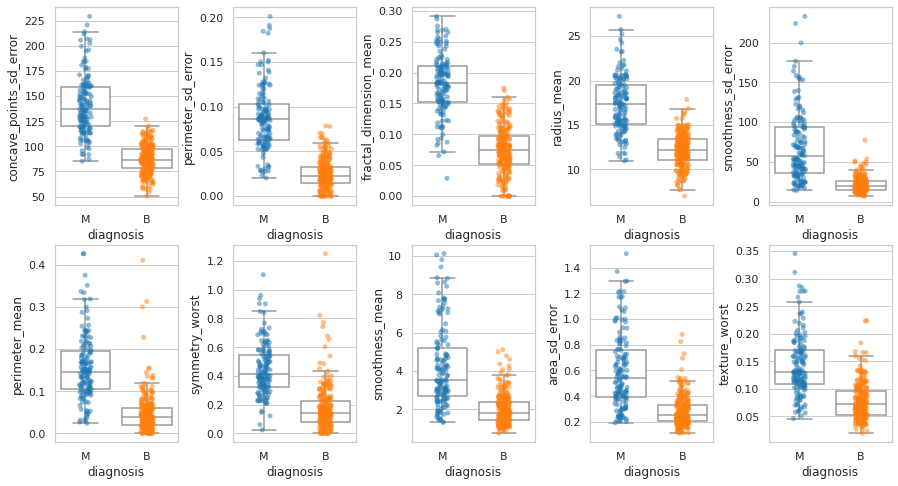

In [47]:
fig, axes = plt.subplots(ncols=5,nrows=2,figsize=(15,8))
axes=axes.flatten()
fig.subplots_adjust(wspace=0.45)
for ii,var in feature_importance.sort_values('Importance',ascending=False).head(10)['Feature'].items():
    sns.boxplot(x='diagnosis',y=var, data=train,
                color='white',order=['M','B'],
                showfliers = False,ax=axes[ii])
    
    sns.stripplot(x='diagnosis',y=var, data=train,
                  palette=['C0','C1'],
                  order=['M','B'],alpha=0.5,ax=axes[ii])

The interquartile ranges of the two classes do not overlap in 9 out of 10 features plotted below. This indicates that the variance in these features are predictive of the tumor class.

Tumors that have greater values for `concave_points_sd_error`, `fractal_dimensional_mean`, `perimeter_sd_error`,  `radius_mean`, `smoothness_sd_error`, `perimeter_mean`, `symmetry_worst`,  `symmetry_sd_error`, `smoothness_mean`,  and `concave_points_mean` are likely to be malignant.

**Advantages of using a random forest classifier (RF) over logistic regression (LR) or SVM classifiers:**
   - RF is less sensitive to outliers compared to LR and SVM models. Presence of outliers in an LR model can significantly impact the slope of the fitted line, and the model is prone to making predictions that are highly skewed towards the outlier data points. Presence of outliers in an SVM model can alter the orientation of the decision boundary which can negatively affect classification.  
   - In RF, feature scaling is not needed; features with different scales have no impact model performance. In LR, feature scaling is recommended so the model can converge faster. In SVM, feature scaling is necessary to ensure equal influence of all feature dimensions in generating the decision boundary.
   - RF models innately mitigate overfitting. An RF model is an ensemble of several weak learners, wherein each learner is randomly assigned some fraction of the dataset to learn class separability. It then aggregates the prediction of all learners and returns the majority prediction. This process of assigning a fraction of training data to multiple weak learners helps mitigating overfitting. 

### Final model

In [48]:
# Combine training and validation sets
train_ = pd.concat([train,val],axis=0)

# Preprocess the training and test data
preproc_pipeline.fit(train_[features])

X_train = pd.DataFrame(preproc_pipeline.transform(train_[features]),columns=features)
y_train = train_['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)

X_test = pd.DataFrame(preproc_pipeline.transform(test[features]),columns=features)
y_test = test['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)

In [49]:
print('RF best hyperparameters:',rf_cv.best_params_)

RF best hyperparameters: {'max_features': 'log2', 'n_estimators': 100}


In [53]:
rf = RandomForestClassifier(n_estimators=100, max_features='log2',class_weight="balanced")
_=rf.fit(X_train,y_train)

In [54]:
_=mean_cv_score(rf,X_train,y_train)
print('\n')
_=mean_cv_score(rf, X_test, y_test, dset='Test')
_report(rf,X_train,y_train)
_report(rf,X_test,y_test,dset='Test')

Train mean accuray: 1.00
Train recall accuray: 1.00


Test mean accuray: 0.98
Test recall accuray: 0.95

Train:
Confusion matrix:
[[288   0]
 [  0 194]]

Test:
Confusion matrix:
[[44  0]
 [ 2 40]]


The final RF model performs reasonably well with a recall score of 0.95 and an accuracy of 0.98. However, it is a matter of concern that 2 malignant tumors were falsely classified as benign in the test set. Ideally we would like to have a 100% recall at the expense of high FPR. Further steps could include lowering the probability threshold to make the model more sensitive to the malignant class. Of course this has to be done when there is new data available to validate and test on.